In [2]:
import pandas as pd
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dados

In [3]:
df = pd.read_csv('./data/fat_votos_ori_gov_2019-2022.csv')

In [4]:
df_dim_prof = pd.read_excel('./data/dim_profissoes_ficha.xlsx')

In [5]:
df_parls_profs = pd.read_csv('./data/fat_profissoes_2019-2023.csv')
df_profs_d = df_parls_profs[['id_parl', 'codTipoProfissao', 'titulo']].merge(df_dim_prof[['codTipoProfissao', 'is_empresario']], on='codTipoProfissao')
df_profs_d = df_profs_d.join(pd.get_dummies(df_profs_d['codTipoProfissao'])).groupby('id_parl').max(numeric_only=True).reset_index()

In [6]:
df_parls = pd.read_csv('./data/dim_parlamentares.csv')

# Agregar

In [7]:
# remover votações cuja orientação seja 0
df = df[df['orient_trat'] != 0].reset_index(drop=True)

df = df.join(pd.get_dummies(df['gov']))

df_g = df.groupby(['ano', 'id'])[[-1, 1]].sum(numeric_only=True).rename({-1: 'v_opo', 1: 'v_gov'}, axis=1).reset_index()

df_g['gov'] = df_g['v_gov'] / (df_g['v_gov'] + df_g['v_opo'])

In [8]:
df_m = df_g.merge(df_profs_d, left_on='id', right_on='id_parl')

# Plotar

In [9]:
empresarios = len(df_profs_d[df_profs_d['is_empresario'] == 1]['id_parl'].unique())
n_empresarios = len(df_profs_d[df_profs_d['is_empresario'] == 0]['id_parl'].unique())
print(f'Total de empresarios: {empresarios}\nTotal não empresários: {n_empresarios}\nTotal: {empresarios + n_empresarios}')

Total de empresarios: 233
Total não empresários: 362
Total: 595


In [10]:
df_uf_partido = df_profs_d.merge(
    df_parls[['id', 'siglaUf', 'siglaPartido']], left_on='id_parl', right_on='id', how='left')
df_uf_partido_g = df_uf_partido[['siglaPartido', 'id_parl']].groupby(
    'siglaPartido').count().reset_index().rename({'id_parl': 'total'}, axis=1)
df_uf_partido_g = df_uf_partido_g.sort_values('total', ascending=False)




In [11]:
def calcular_empresarios(partido):
    return len(df_uf_partido[(df_uf_partido['siglaPartido'] == partido) & (df_uf_partido['is_empresario'] ==1)])

In [12]:
df_uf_partido_g['total_empr'] = df_uf_partido_g['siglaPartido'].apply(calcular_empresarios)
df_uf_partido_g['%_do_partido'] = df_uf_partido_g['total_empr'] / df_uf_partido_g['total'] * 100
df_uf_partido_g['%_do_total_empr'] = df_uf_partido_g['total_empr'] / empresarios * 100

In [13]:
df_uf_partido_g.sort_values('%_do_total_empr', ascending=False)

,siglaPartido,total,total_empr,%_do_partido,%_do_total_empr


## Governismo (pooled)

,Não Empresários,Empresários
min,0.00,0.00
max,1.00,1.00
mean,0.73,0.84
std,0.27,0.19
count,1317.00,845.00


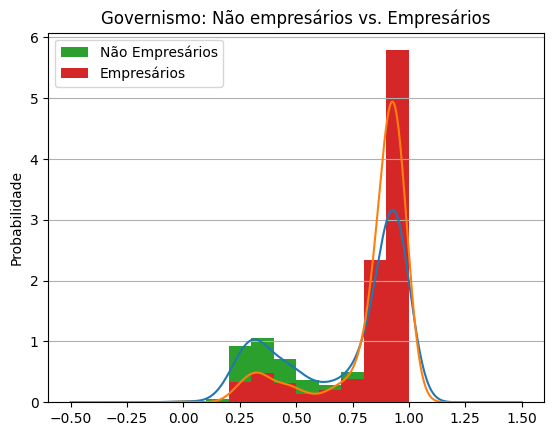

In [15]:
df_plot = pd.DataFrame()
df_plot['Não Empresários'] = [g for g in df_m[df_m['is_empresario'] == 0]['gov']]
df_ne =pd.DataFrame({'Empresários': [g for g in df_m[df_m['is_empresario'] == 1]['gov']]})

df_plot=pd.concat([df_plot, df_ne], ignore_index=False, axis=1)

display(df_plot.agg(['min', 'max', 'mean', 'std', 'count']).round(decimals=2))

fig, ax = plt.subplots()
df_plot.plot.kde(ax=ax, legend=False, title='Governismo: Não empresários vs. Empresários')
df_plot.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probabilidade')
ax.grid(axis='y')

## Partidos

In [16]:
df_d_p = df_m.merge(df_parls[['id', 'siglaPartido', 'siglaUf']], on='id', how='left')

df_d_p.drop_duplicates(['id', 'Empresária', 'Empresário'], inplace=True)

df_partidos = df_d_p.groupby('siglaPartido').agg({'id': 'count', 'Empresária': 'sum', 'Empresário': 'sum'})

df_partidos['%'] = (df_partidos['Empresária'] + df_partidos['Empresário']) / df_partidos['id'] * 100

df_partidos = df_partidos.sort_values('%', ascending=False)

KeyError: Index(['Empresária', 'Empresário'], dtype='object')

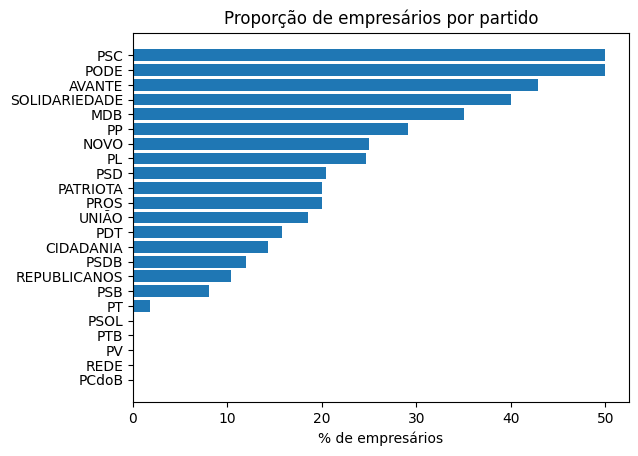

In [16]:
fig, ax = plt.subplots()
partidos = df_partidos.index
prop = df_partidos['%']

ax.barh(partidos, prop)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(r'% de empresários')
ax.set_title('Proporção de empresários por partido')

plt.show()

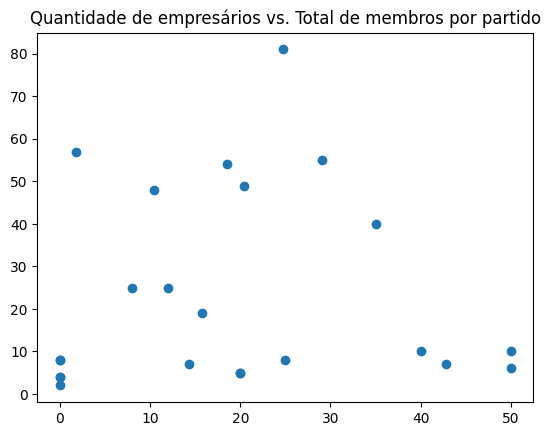

In [17]:
fig, ax = plt.subplots()

ax.scatter(df_partidos['%'], df_partidos['id'])

ax.set_title('Quantidade de empresários vs. Total de membros por partido')
plt.show()